In [1]:
from string import ascii_letters
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Tensorflow
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Flatten, CuDNNLSTM, Bidirectional, Input, concatenate, Dropout
from keras.utils import to_categorical

# Numpy
import numpy as np
from numpy import zeros

# Gemsim
import gensim.models

In [2]:
run_random_forests = False

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
class MyCorpus:
        """An iterator that yields sentences (lists of str)."""
        def __init__(self, text_list: list):
            self.text_list = text_list

        def __iter__(self):
            for line in self.text_list:
                yield line

In [20]:
# Read the data
# df = pd.read_csv('../features/combination.csv')
df = pd.read_csv('../features/combination_zhenhao.csv')
# df = pd.read_csv('../features/web2py.csv')
# df = pd.read_csv('../features/neutron.csv')
# df = pd.read_csv('../features/neutron_zhenhao.csv')
# df = pd.read_csv('../features/nova.csv')
# df = pd.read_csv('../features/nova_zhenhao.csv')
# df = pd.read_csv('../features/django.csv')
# df = pd.read_csv('../features/django_zhenhao.csv')
# df = pd.read_csv('../features/tornado.csv')
# df = pd.read_csv('../features/tornado_zhenhao.csv')

no_log_cnt, log_cnt = df['contains_logging'].value_counts()
par_vec_cnt = no_log_cnt + log_cnt
log_ratio = log_cnt / par_vec_cnt
print(f"Number of parameter vecs:\t\t{par_vec_cnt}")
print(f"without logging (negatives):\t{no_log_cnt}")
print(f"with logging (positives):\t\t{log_cnt}")
print(f"Log ratio:\t\t\t\t\t\t{log_ratio * 100:.2f}%")
print(df.shape)
df.head()

Number of parameter vecs:		215535
without logging (negatives):	208989
with logging (positives):		6546
Log ratio:						3.04%
(215535, 3)


,type,context,contains_logging
0,c,cmmenhnmnmnndximjtmndmnnmmq,0
1,e,cmmenhnmnmnndximjtmndmnnmm,0
2,h,cmmenhnmn,0
3,d,cmmenhnmnmnndx,0
4,i,cmmenhnmnmnndxim,0


In [232]:
# Convert the compacted context from letters into strings of integers
df.context = [list(map(lambda y: str(ascii_letters.index(y)), list(x))) for x in df.context]
df.head()

,type,parent,context,contains_class_definition,contains_function_definition,contains_if_statement,contains_for_statement,contains_while_statement,contains_try_statement,contains_with_statement,...,contains_exec_statement,contains_future_import_statement,contains_global_statement,contains_nonlocal_statement,contains_print_statement,contains_assignment,contains_call,contains_await,contains_yield,contains_logging
0,g,a,"[0, 21, 6, 21]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,k,g,"[0, 21, 6, 21, 10, 23]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,d,a,"[0, 21, 21, 22, 3, 13, 13]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,c,a,"[2, 12, 12, 4, 13, 7, 13, 12, 13, 12, 13, 13, ...",0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,c,a,"[2, 12, 3, 12, 8, 12, 9, 12, 16]",0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [233]:
# Word2Vec Model
sentences = MyCorpus(list(df.context))
gensim_model = gensim.models.Word2Vec(sentences=sentences, min_count=1)
actual_vocab_size = len(gensim_model.wv.key_to_index)
actual_vocab_size

27

In [234]:
# Build an embedding for each context as the mean of its words' Word2Vec vectors
corpus_embeddings = []
for doc in sentences:
    doc_embedding = np.zeros((len(doc), 100), dtype=np.float32)
    for idx, word in enumerate(doc):
                    doc_embedding[idx] = gensim_model.wv[word]
    doc_embedding = np.mean(doc_embedding, axis=0)
    corpus_embeddings.append(doc_embedding)
corpus_embeddings = np.array(corpus_embeddings)
df_corpus_embeddings = pd.DataFrame(corpus_embeddings, columns=["c"+str(i) for i in range(100)])
df_corpus_embeddings.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
0,-0.368256,0.971962,1.201707,1.182384,-0.522340,-0.452860,0.663316,1.163669,-0.770460,-0.662516,...,0.141778,-0.180991,-0.510744,-0.140895,0.744607,-0.212446,-0.468561,-0.385236,0.174969,-0.878117
1,-0.521384,0.770887,0.554832,1.421003,-0.565617,-0.252370,0.366726,0.809759,-0.888896,-0.217304,...,0.142205,-0.207796,-0.293615,-0.130738,0.428609,-0.483853,-0.369993,0.151211,0.072677,-0.404657
2,-0.211938,0.756774,0.622358,0.496400,-0.228704,-0.685327,0.347765,0.651059,-0.524499,-0.466459,...,0.082722,0.143299,-0.366491,0.092826,0.205942,-0.295147,-0.336288,-0.569875,-0.168339,-0.684264
3,0.638764,0.048132,-0.206513,-0.187402,0.321105,-0.042717,0.143330,-0.068713,-0.041244,0.183967,...,0.026349,-0.051463,-0.239925,0.613871,-0.730917,-0.700165,-0.150192,-0.053066,-0.600852,0.252561
4,0.537286,-0.013061,-0.413410,-0.515359,0.488086,0.087427,0.112958,0.086412,0.034415,0.076970,...,0.134673,0.014234,-0.153983,0.597337,-0.597733,-0.847547,0.000744,0.031055,-0.484328,0.170059


In [235]:
# TF-IDF
vectorizer = TfidfVectorizer(token_pattern="\w+")
concat_context = [" ".join(x) for x in df.context]
vectorize_res = vectorizer.fit_transform(concat_context)
df_tfidf = pd.DataFrame(vectorize_res.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf.head()

,0,1,10,11,12,13,15,16,17,18,...,26,27,29,3,4,5,6,7,8,9
0,0.475286,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.248167,0.000000,0.000000,0.000000
1,0.425020,0.0,0.252546,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.221921,0.000000,0.000000,0.000000
2,0.438380,0.0,0.000000,0.0,0.000000,0.202452,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.136074,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.000000,0.0,0.663635,0.522289,0.0,0.116316,0.0,0.0,...,0.0,0.0,0.0,0.175523,0.139186,0.0,0.000000,0.229972,0.178180,0.138757
4,0.000000,0.0,0.000000,0.0,0.730347,0.000000,0.0,0.288020,0.0,0.0,...,0.0,0.0,0.0,0.217313,0.000000,0.0,0.000000,0.000000,0.441206,0.343588


In [236]:
score_names = [
    "Balanced accuracy score",
    "Precision score",
    "Recall score",
    "F1 Binary"
]

regular
Balanced accuracy score    0.629
Precision score            0.722
Recall score               0.261
F1 Binary                  0.383
dtype: float64


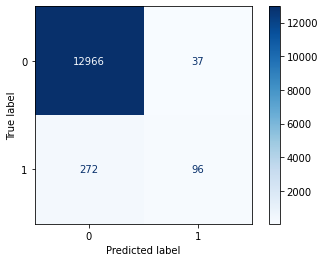

corpus
Balanced accuracy score    0.536
Precision score            0.225
Recall score               0.079
F1 Binary                  0.117
dtype: float64


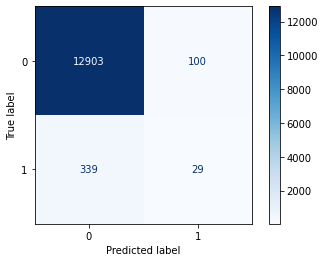

tf-idf
Balanced accuracy score    0.531
Precision score            0.205
Recall score               0.071
F1 Binary                  0.105
dtype: float64


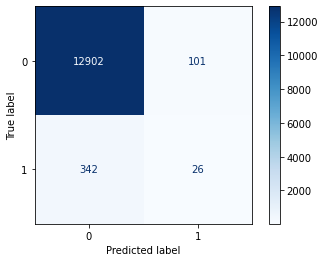

regular+corpus
Balanced accuracy score    0.551
Precision score            0.379
Recall score               0.106
F1 Binary                  0.166
dtype: float64


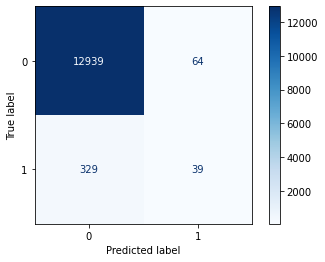

regular+tfidf
Balanced accuracy score    0.565
Precision score            0.576
Recall score               0.133
F1 Binary                  0.216
dtype: float64


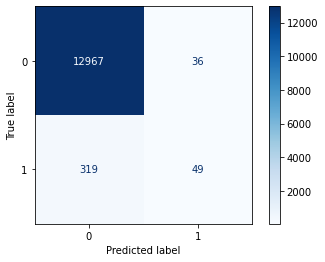

corpus+tfidf
Balanced accuracy score    0.540
Precision score            0.250
Recall score               0.087
F1 Binary                  0.129
dtype: float64


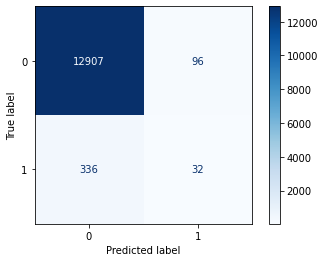

regular+corpus+tfidf
Balanced accuracy score    0.556
Precision score            0.377
Recall score               0.117
F1 Binary                  0.178
dtype: float64


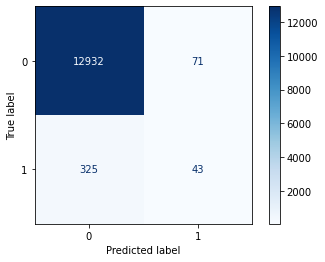

In [237]:
# Simple Random Forest Run

if run_random_forests:
    df_regular = df.drop(["context"], axis=1)
    dataframes = [
        ("regular", df_regular),
        ("corpus", df_corpus_embeddings.join(pd.DataFrame(df.contains_logging))),
        ("tf-idf", df_tfidf.join(pd.DataFrame(df.contains_logging))),
        ("regular+corpus", df_regular.join(df_corpus_embeddings)),
        ("regular+tfidf", df_regular.join(df_tfidf)),
        ("corpus+tfidf", df_corpus_embeddings.join(df_tfidf).join(pd.DataFrame(df.contains_logging))),
        ("regular+corpus+tfidf", df_regular.join(df_corpus_embeddings).join(df_tfidf)),
    ]

    for df_name, df_used in dataframes:
        print(df_name)
        # Split data into train and test sets
        X = df_used.drop(["contains_logging"], axis=1)
        if "regular" in df_name:
            X = pd.get_dummies(X, columns=["type", "parent"])
        y = df_used.contains_logging
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=0)
        # X_train.head()
        classifier = RandomForestClassifier(n_estimators=9, random_state=0)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        scores = [
                balanced_accuracy_score(y_test, y_pred),
                precision_score(y_test, y_pred),
                recall_score(y_test, y_pred),
                f1_score(y_test, y_pred, average='binary', pos_label=True)
        ]
        cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
        score_df = pd.DataFrame([scores], columns=score_names).mean().round(3)
        print(score_df)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=classifier.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

regular
Balanced accuracy score    0.621
Precision score            0.750
Recall score               0.245
F1 Binary                  0.368
dtype: float64


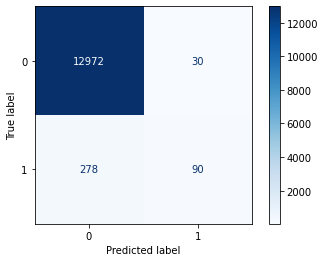

corpus
Balanced accuracy score    0.531
Precision score            0.201
Recall score               0.071
F1 Binary                  0.105
dtype: float64


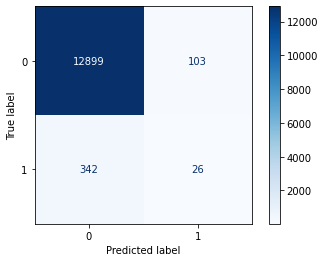

tf-idf
Balanced accuracy score    0.534
Precision score            0.210
Recall score               0.076
F1 Binary                  0.112
dtype: float64


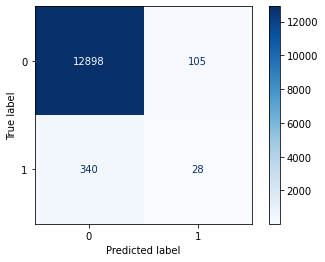

regular+corpus
Balanced accuracy score    0.545
Precision score            0.331
Recall score               0.096
F1 Binary                  0.149
dtype: float64


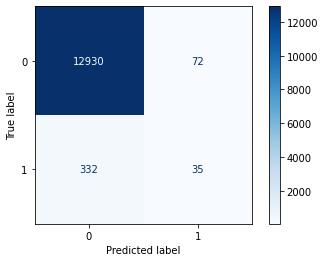

regular+tfidf
Balanced accuracy score    0.566
Precision score            0.582
Recall score               0.135
F1 Binary                  0.219
dtype: float64


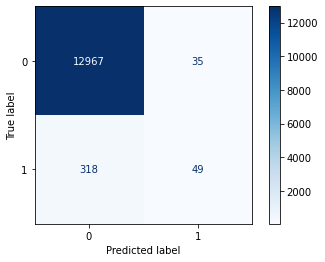

corpus+tfidf
Balanced accuracy score    0.533
Precision score            0.210
Recall score               0.075
F1 Binary                  0.110
dtype: float64


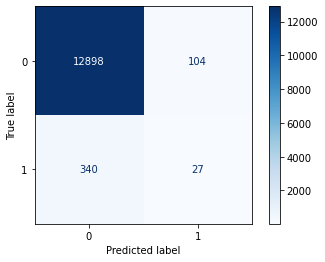

regular+corpus+tfidf
Balanced accuracy score    0.552
Precision score            0.373
Recall score               0.110
F1 Binary                  0.170
dtype: float64


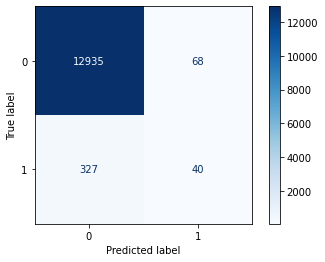

In [238]:
# Folded Random Forest Run

df_regular = df.drop(["context"], axis=1)
if run_random_forests:
    dataframes = [
        ("regular", df_regular),
        ("corpus", df_corpus_embeddings.join(pd.DataFrame(df.contains_logging))),
        ("tf-idf", df_tfidf.join(pd.DataFrame(df.contains_logging))),
        ("regular+corpus", df_regular.join(df_corpus_embeddings)),
        ("regular+tfidf", df_regular.join(df_tfidf)),
        ("corpus+tfidf", df_corpus_embeddings.join(df_tfidf).join(pd.DataFrame(df.contains_logging))),
        ("regular+corpus+tfidf", df_regular.join(df_corpus_embeddings).join(df_tfidf)),
    ]

    for df_name, df_used in dataframes:
        print(df_name)
        all_scores = []
        conf_matrices = []
        # Split data into train and test sets
        X = df_used.drop(["contains_logging"], axis=1)
        if "regular" in df_name:
            X = pd.get_dummies(X, columns=["type", "parent"])
        y = df_used.contains_logging
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=0)
        # classifier = RandomForestClassifier(n_estimators=200, random_state=0)
        classifier = RandomForestClassifier(n_estimators=9, random_state=0)
        skf = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            scores = [
                    balanced_accuracy_score(y_test, y_pred),
                    precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred),
                    f1_score(y_test, y_pred, average='binary', pos_label=True)
            ]
            all_scores.append(scores)
            cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
            conf_matrices.append(cm)
        score_df = pd.DataFrame(all_scores, columns=score_names).mean().round(3)
        print(score_df)
        avg_cm = np.mean(conf_matrices, axis=0).astype(int)
        disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm,
                                      display_labels=classifier.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

In [243]:
# Data split for Tensorflow

X = df.drop(["contains_logging"], axis=1)
X = pd.get_dummies(X, columns=["type", "parent"])
y = df.contains_logging
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=0)
X_train

,context,contains_class_definition,contains_function_definition,contains_if_statement,contains_for_statement,contains_while_statement,contains_try_statement,contains_with_statement,contains_return_statement,contains_assert_statement,...,parent_c,parent_d,parent_e,parent_f,parent_g,parent_h,parent_i,parent_j,parent_k,parent_l
13543,"[2, 12, 13, 3, 12, 12, 13, 12, 13, 3, 13, 9, 13]",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
35966,"[2, 12, 3, 13, 16, 13]",0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
21749,"[2, 2, 12, 13, 12, 13, 12, 13, 12, 13, 2, 12, ...",0,0,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8961,"[2, 16]",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2679,"[2, 16, 13]",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36468,"[2, 13, 2, 3, 13, 13, 16, 13, 13, 9, 16, 2, 3,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
31183,"[2, 3, 3, 12, 13, 3, 3, 13, 12, 13, 9, 12, 13,...",0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
8459,"[2, 12, 13, 12, 13, 12, 13, 13, 12, 13, 12, 13...",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20681,"[2, 12, 4, 13, 3, 13, 12, 18]",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [250]:
vocab_size = 30
output_dims = 100
max_length = 80
num_epochs = 100
batch_size = 24
dropout = 0.2

In [253]:
# Build embedding matrix
embedding_matrix = zeros((vocab_size, output_dims))
for i in range(vocab_size):
    embedding_vector = None
    try:
        embedding_vector = gensim_model.wv[str(i)]
    except KeyError:
        pass
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
# embedding_matrix

array([[ 2.16098040e-01,  1.48762751e+00,  1.79505408e+00, ...,
        -1.23306799e+00, -3.75583619e-01, -1.42227471e+00],
       [ 3.96291353e-02,  6.78083241e-01,  7.14575797e-02, ...,
        -6.67472899e-01,  6.30375564e-01,  1.38690042e+00],
       [ 2.12420344e-01,  3.97649050e-01,  4.06255201e-02, ...,
         9.37355235e-02,  4.76882905e-01,  1.98397607e-01],
       ...,
       [-6.46759495e-02,  2.55506575e-01,  2.05601677e-01, ...,
        -1.34416616e+00, -7.60651648e-01, -1.46729290e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.09221411e-01,  5.91012895e-01,  3.35809052e-01, ...,
         3.63320202e-01, -1.07530165e+00,  1.01342940e+00]])

In [252]:
# Pad the context to create the context input
padded_inputs = pad_sequences(np.array(list(X_train.context), dtype=object), maxlen=max_length, value=0.0)  # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(np.array(list(X_test.context), dtype=object), maxlen=max_length, value=0.0)  # 0.0 because it corresponds with <PAD>
# padded_inputs

array([[ 0,  0,  0, ..., 13,  9, 13],
       [ 0,  0,  0, ..., 13, 16, 13],
       [13, 13,  3, ..., 12,  9, 18],
       ...,
       [ 0,  0,  0, ..., 12, 13, 13],
       [ 0,  0,  0, ..., 13, 12, 18],
       [ 0,  0,  0, ...,  2, 13, 13]], dtype=int32)

In [266]:
# Prepare the "other" input
regular_inputs = X_train.drop(["context"], axis=1)
regular_inputs_test = X_test.drop(["context"], axis=1)
# regular_inputs

,contains_class_definition,contains_function_definition,contains_if_statement,contains_for_statement,contains_while_statement,contains_try_statement,contains_with_statement,contains_return_statement,contains_assert_statement,contains_break_statement,...,parent_c,parent_d,parent_e,parent_f,parent_g,parent_h,parent_i,parent_j,parent_k,parent_l
13543,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
35966,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
21749,0,0,1,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8961,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2679,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
31183,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
8459,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20681,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Build and run the tensorflow model using both the context and the other features as inputs

context_input = keras.Input(shape=(max_length,), name="context")
other_input = keras.Input(shape=(regular_inputs.shape[1],), name="other")

context_features = keras.layers.Embedding(vocab_size, output_dims, weights=[embedding_matrix], trainable=False)(context_input) # input_length?
# context_features = keras.layers.LSTM(128, return_sequences=True)(context_features) # dropout?
# context_features = keras.layers.LSTM(128)(context_features)
context_features = keras.layers.CuDNNLSTM(128, return_sequences=True)(context_features) # dropout?
context_features = keras.layers.CuDNNLSTM(128)(context_features)
context_features = keras.layers.Dense(32)(context_features)

other_features = keras.layers.Dense(300, activation='relu')(other_input)
other_features = keras.layers.Dense(100, activation='relu')(other_features)
other_features = keras.layers.Dense(40, activation='relu')(other_features)

x = keras.layers.concatenate([context_features, other_features])

logging_pred = keras.layers.Dense(1, name="logging", activation='sigmoid')(x) # Sigmoid?

model = keras.Model(
    inputs=[context_input, other_input],
    outputs=[logging_pred],
)
# model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    {"context": padded_inputs, "other": regular_inputs},
    {"logging": y_train},
    epochs=num_epochs,
    batch_size=batch_size,
)
pred_test= model.predict({"context": padded_inputs_test, "other": regular_inputs_test})
y_pred = np.round(pred_test)
scores = [
        "web2py_combined",
        max_length,
        vocab_size,
        batch_size,
        # trainable,
        dropout,
        # sigmoid,
        # val_split,
        # callback,
        f"{balanced_accuracy_score(y_test, y_pred):.2f}"[2:],
        f"{precision_score(y_test, y_pred):.2f}"[2:],
        f"{recall_score(y_test, y_pred):.2f}"[2:],
        f"{f1_score(y_test, y_pred):.2f}"[2:],
    ]
out = open("results.txt", "a")
out.write("Name, max_length, vocab_size, batch_size, dropout, Bal_Acc, Precision, Recall, F1_Score")
out.write("\n")
out.write(str(scores).replace("'", "")[1:-1])
out.write("\n")
out.close()